## Quick learn

The goal is to make a model and do some validation. Zero time tuning.

In [1]:
from PIL import Image
from glob import glob
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Make a function for computing luminance:

$$Y = 0.2126 R + 0.7152 G + 0.0722 B$$

In [2]:
def luminance(r, g, b):
    return 0.2126*r + 0.7152*g + 0.0722*b

Make lists of ravelled arrays.

In [3]:
def get_data(pathname):
    files = []
    for fname in glob(pathname):
        img = Image.open(fname)  # Image
        ima = np.asarray(img)    # array
        imy = luminance(*ima.T)   # luminance
        files.append(imy.ravel())
    return files

In [8]:
pathname = '/home/matt/Downloads/seals/StitchMICE_ORKlh16_3_1104_CP_FINAL_tiles/pos/*.tif'
pos = get_data(pathname)

pathname = '/home/matt/Downloads/seals/StitchMICE_ORKlh16_3_1104_CP_FINAL_tiles/neg/*.tif'
neg = get_data(pathname)

In [9]:
len(pos), len(neg)

(3041, 7000)

In [10]:
X = np.array(pos + neg)
y = np.array([1] * len(pos) + [0] * len(neg))

In [11]:
X.shape, y.shape

((10041, 6400), (10041,))

## Train and test

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [14]:
X_train.shape

(7530, 6400)

## Random forest

Let's start with something simple and fast that wil probably work.

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
clf = RandomForestClassifier(n_jobs=8, n_estimators=16)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
clf.score(X_train, y_train), clf.score(X_val, y_val)

(0.999203187250996, 0.9745121465551573)

In [18]:
y_pred = clf.predict(X_val)

In [19]:
y_prob = clf.predict_proba(X_val)[:, 1]

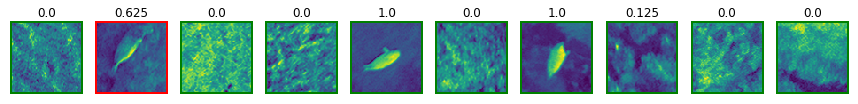

In [20]:
offset = 510
number = 10

fig, axs = plt.subplots(ncols=number, figsize=(15,1.5))
for i, ax in enumerate(axs):
    idx = offset + i
    xa = X_val[idx].reshape(80, 80)
    #xa = xi.reshape(80, 80)
    ax.imshow(xa)
    ax.set_xticks([])
    ax.set_yticks([])
    #axs[i].set_title(f"{y_val[idx], y_pred[idx]}")
    ax.set_title(f"{y_prob[idx]}")
    c = 'green' if (y_pred[idx] == y_val[idx]) else 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(2)

The number above each plot is the probability of seal according to the classifier. If this number is below 0.5, then the classifier is predicting 'not seal'. Image index 518 is surprising &mdash; I'd have expected the model to emit something greater than 0 for this image.

If the frame of the plot is green, the the classifier's prediction was correct.

### Most equivocal images

Let's look at those images with a probability near 0.5. We would expect most of the incorrect predictions to be on those images.

In [21]:
most_equivocal_idx = np.argsort(np.abs(y_prob - 0.5))

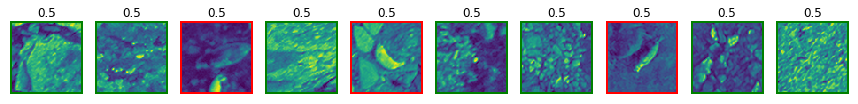

In [22]:
number = 10
fig, axs = plt.subplots(ncols=number, figsize=(15,1.5))

for ax, idx in zip(axs, most_equivocal_idx[:number]):
    ax.imshow(X_val[idx].reshape(80, 80))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{y_prob[idx]}")
    c = 'green' if (y_pred[idx] == y_val[idx]) else 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(2)

## Other models

### Support vector machine

In [23]:
from sklearn.svm import SVC

This is slow with more than about 2000 examples.

In [26]:
svc = SVC(gamma='scale')

# svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
svc.score(X_train, y_train), clf.score(X_val, y_val)

(0.999867197875166, 0.9745121465551573)

Definitely not worth the extra computation time!

### Gradient boosted trees

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [30]:
clf.score(X_train, y_train), clf.score(X_val, y_val)

(0.995750332005312, 0.9753086419753086)

A small improvement!